In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

# Load the Data

In [3]:
# result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_complete/"
# with open('/homes/me466/cem/experiments/configs/cub_mixcem_complete.yaml', "r") as f:
#     experiment_config = yaml.load(f, Loader=yaml.FullLoader)

result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_incomplete/"
with open('/homes/me466/cem/experiments/configs/cub_mixcem_incomplete.yaml', "r") as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

# id_dataset_config =  {
#     "dataset": "awa2",
#     "num_workers": 8,
#     "batch_size": 512,

#     # DATASET VARIABLES
#     "root_dir": "/anfs/bigdisc/me466/AwA2/Animals_with_Attributes2",
#     "sampling_percent": 0.1,
#     "sampling_groups": False,
#     "test_subsampling": 1,
#     "weight_loss": False,
# }

id_dataset_config =  {
    "dataset": "cub",
    "num_workers": 8,
    "batch_size": 64,

    # DATASET VARIABLES
    "root_dir": "/homes/me466/data/CUB200/",
    "sampling_percent": 0.25 if "cub_incomplete" in result_dir else 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": True,
}

In [4]:
import cem.utils.data as data_utils
# import cem.data.awa2_loader as data_module
import cem.data.CUB200.cub_loader as data_module
from cem.data.utils import transform_from_config

# test_transform_config = dict(
#     name='salt_and_pepper',
#     s_vs_p=0.5,
#     amount=0.1,
# )

test_transform_config = dict(
    name='random_noise',
    low_noise_level=1,
    noise_level=0.5,
)

test_transform_fn = transform_from_config(test_transform_config)
_, _, id_test_dl, _, (n_concepts, n_tasks, concept_map) = \
    data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
    )
id_x_test, id_y_test, id_c_test = data_utils.daloader_to_memory(id_test_dl)


_, _, ood_test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
        test_sample_transform=test_transform_fn,
    )
ood_x_test, ood_y_test, ood_c_test = data_utils.daloader_to_memory(ood_test_dl)

Global seed set to 42


		Selected concepts: [0, 1, 2, 3, 37, 38, 39, 40, 41, 42, 43, 44, 51, 52, 76, 77, 86, 87, 88, 99, 100, 101]
		Updated concept group map (with 7 groups):
			has_bill_shape -> [0, 1, 2, 3]
			has_head_pattern -> [4, 5]
			has_breast_color -> [6, 7, 8, 9, 10, 11]
			has_bill_length -> [12, 13]
			has_wing_shape -> [14, 15]
			has_tail_pattern -> [16, 17, 18]
			has_bill_color -> [19, 20, 21]


Global seed set to 42


		Selected concepts: [0, 1, 2, 3, 37, 38, 39, 40, 41, 42, 43, 44, 51, 52, 76, 77, 86, 87, 88, 99, 100, 101]
		Updated concept group map (with 7 groups):
			has_bill_shape -> [0, 1, 2, 3]
			has_head_pattern -> [4, 5]
			has_breast_color -> [6, 7, 8, 9, 10, 11]
			has_bill_length -> [12, 13]
			has_wing_shape -> [14, 15]
			has_tail_pattern -> [16, 17, 18]
			has_bill_color -> [19, 20, 21]


# Load the Models to be Used

In [5]:
import experiments.experiment_utils as experiment_utils
import joblib
split = 0
selected_models = joblib.load(
    os.path.join(result_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'),
)

In [6]:
models_to_include = [
    ("Hybrid CBM", "Hybrid-CBM (Baseline)"),
    ("CEM", "CEM (Baseline)"),
    ("IntCEM", "IntCEM (Baseline)"),
    ("MixCEM", "Entropy CMCMixCEM (Baseline)"),
]

# Generate the Bottlenecks

In [7]:
from cem.models.construction import load_trained_model
import pytorch_lightning as pl

id_y_preds = []
id_c_preds = []
id_bottlenecks = []

id_int_y_preds = []
id_int_c_preds = []
id_int_bottlenecks = []

ood_y_preds = []
ood_c_preds = []
ood_bottlenecks = []
ood_int_y_preds = []
ood_int_c_preds = []
ood_int_bottlenecks = []

for real_model_name, used_model_name in models_to_include:
    root = selected_models[used_model_name]
    model_config = joblib.load(
        os.path.join(result_dir, root + "_experiment_config.joblib"),
    )

    task_class_weights = None
    model = load_trained_model(
        config=model_config,
        n_tasks=n_tasks,
        result_dir=result_dir,
        n_concepts=n_concepts,
        split=split,
        imbalance=imbalance,
        task_class_weights=task_class_weights,
        train_dl=None,
        logger=False,
        output_latent=False,
        output_interventions=False,
        enable_checkpointing=False,
    )
    trainer = pl.Trainer(
        gpus=1,
        logger=False,
    )

    print("Unintervened ID Bottlenecks for", real_model_name)
    id_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )

    id_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))
    id_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))
    id_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))

    print("Unintervened OOD Bottlenecks for", real_model_name)
    ood_test_batch_results = trainer.predict(
        model,
        ood_test_dl,
    )
    ood_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))
    ood_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))
    ood_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))

    model.force_all_interventions = True
    print("Intervened ID Bottlenecks for", real_model_name)
    id_int_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )

    id_int_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))
    id_int_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))
    id_int_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))

    print("Intervened OOD Bottlenecks for", real_model_name)
    ood_int_test_batch_results = trainer.predict(
        model,
        ood_test_dl,
    )
    ood_int_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))
    ood_int_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))
    ood_int_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Unintervened ID Bottlenecks for Hybrid CBM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Unintervened OOD Bottlenecks for Hybrid CBM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Unintervened ID Bottlenecks for CEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Unintervened OOD Bottlenecks for CEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Intervened ID Bottlenecks for CEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Unintervened ID Bottlenecks for IntCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Unintervened OOD Bottlenecks for IntCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Intervened ID Bottlenecks for IntCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Intervened OOD Bottlenecks for IntCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Unintervened ID Bottlenecks for MixCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Unintervened OOD Bottlenecks for MixCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Intervened ID Bottlenecks for MixCEM


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

# Visualize the Bottlenecks

In [16]:
from sklearn.manifold import TSNE
import random
random.seed(42)
np.random.seed(42)

freq = 10
perplexity = 50
n_iter = 1000
tsne_no_int_bottlenecks = []
tsne_int_bottlenecks = []
used_subset = list(range(0, id_bottlenecks[0].shape[0], freq))
n_samples = len(used_subset)
for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
    print("Projecting bottlenecks for", real_model_name)
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_bottleneck_data =  np.concatenate(
        [
            np.reshape(id_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
            np.reshape(ood_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
        ],
        axis=0,
    )
    tsne_no_int_bottlenecks.append(
        test_tsne.fit_transform(merged_bottleneck_data)
    )

    merged_bottleneck_data =  np.concatenate(
        [
            np.reshape(id_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
            np.reshape(ood_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
        ],
        axis=0,
    )
    tsne_int_bottlenecks.append(
        test_tsne.fit_transform(merged_bottleneck_data)
    )

Projecting bottlenecks for Hybrid CBM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 0.659398


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.520370
[t-SNE] KL divergence after 1000 iterations: 0.859459
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 0.665548


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.386978
[t-SNE] KL divergence after 1000 iterations: 0.824992
Projecting bottlenecks for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 7.255189


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.808498
[t-SNE] KL divergence after 1000 iterations: 1.044483
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 16.078171


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.047554
[t-SNE] KL divergence after 1000 iterations: 0.817862
Projecting bottlenecks for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 4.424531


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.344109
[t-SNE] KL divergence after 1000 iterations: 1.082623
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 15.841559


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.425079
[t-SNE] KL divergence after 1000 iterations: 0.876839
Projecting bottlenecks for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.001s...
[t-SNE] Computed neighbors for 1160 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 2.809463


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.478741
[t-SNE] KL divergence after 1000 iterations: 1.221020
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.001s...
[t-SNE] Computed neighbors for 1160 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 14.797629


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.765141
[t-SNE] KL divergence after 1000 iterations: 0.829164


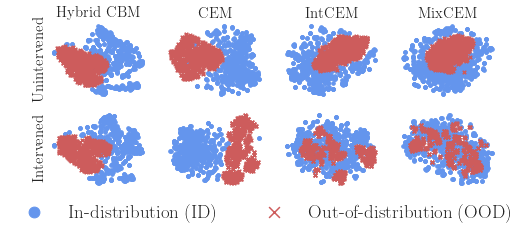

In [17]:
figsize = (2 * len(models_to_include), 3)
fig, axs = plt.subplots(
    2,
    len(models_to_include),
    figsize=figsize,
)

id_color = 'cornflowerblue'
ood_color = 'indianred'

for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
    ax = axs[0, model_idx]
    ax.scatter(
        tsne_no_int_bottlenecks[model_idx][:n_samples, 0],
        tsne_no_int_bottlenecks[model_idx][:n_samples, 1],
        color=id_color,
        label=f"In-distribution (ID)",
        marker='o',
        alpha=1,
        s=13,
    )
    ax.scatter(
        tsne_no_int_bottlenecks[model_idx][n_samples:, 0],
        tsne_no_int_bottlenecks[model_idx][n_samples:, 1],
        color=ood_color,
        label=f"Out-of-distribution (OOD)",
        marker='x',
        alpha=1,
        s=13,
    )

    ax.set_title(real_model_name, fontsize=15)
    if model_idx == 0:
        ax.set_ylabel("Unintervened", fontsize=15)
    ax.grid(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax = axs[1, model_idx]
    ax.scatter(
        tsne_int_bottlenecks[model_idx][:n_samples, 0],
        tsne_int_bottlenecks[model_idx][:n_samples, 1],
        color=id_color,
        label=f"In-distribution (ID)",
        marker='o',
        alpha=1,
        s=13,
    )
    ax.scatter(
        tsne_int_bottlenecks[model_idx][n_samples:, 0],
        tsne_int_bottlenecks[model_idx][n_samples:, 1],
        color=ood_color,
        label=f"Out-of-distribution (OOD)",
        marker='x',
        alpha=1,
        s=13,
    )

    if model_idx == 0:
        ax.set_ylabel("Intervened", fontsize=15)
    ax.grid(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=19,
    loc='upper center',
    bbox_to_anchor=(-1.4,0),
    ncol=2,
    markerscale=3.,
)
plt.savefig(f"figures/bottleneck_intervention_viz.pdf", bbox_inches='tight')
plt.savefig(f"figures/bottleneck_intervention_viz.png", bbox_inches='tight')
plt.show()

# Visualize the actual embeddings

In [44]:
# First we load our mixcem model so that we can include the global embeddings
# as part of the plot
mixcem_root = selected_models["Entropy CMCMixCEM (Baseline)"]
mixcem_model_config = joblib.load(
    os.path.join(result_dir, root + "_experiment_config.joblib"),
)

mixcem = load_trained_model(
    config=mixcem_model_config,
    n_tasks=n_tasks,
    result_dir=result_dir,
    n_concepts=n_concepts,
    split=split,
    imbalance=imbalance,
    task_class_weights=task_class_weights,
    train_dl=None,
    logger=False,
    output_latent=False,
    output_interventions=False,
    enable_checkpointing=False,
)


In [78]:
from sklearn.manifold import TSNE
import random
random.seed(42)
np.random.seed(42)

freq = 10
perplexity = 50
n_iter = 1000
selected_concepts = [0, 1] #list(range(0, 22, 2))

tsne_int_embeddings = []
for selected_concept in selected_concepts:
    used_subset = list(range(0, id_bottlenecks[0].shape[0], freq))
    n_samples = len(used_subset)
    concept_embs = []
    tsne_int_embeddings.append(concept_embs)
    for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
        if real_model_name == "Hybrid CBM":
            continue
        emb_size = 16
        print("Projecting embedings for", real_model_name)
        test_tsne = TSNE(
            n_components=2,
            verbose=1,
            perplexity=perplexity,
            n_iter=n_iter,
            init='pca',
            learning_rate='auto',
        )
        if real_model_name == "MixCEM":
            merged_bottleneck_data =  np.concatenate(
                [
                    mixcem.concept_embeddings[selected_concept, :, :].detach().cpu().numpy(),
                    id_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,emb_size:2*emb_size],
                    # id_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,:emb_size],
                    ood_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,emb_size:2*emb_size],
                    # ood_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,:emb_size],
                ],
                axis=0,
            )

        else:
            merged_bottleneck_data =  np.concatenate(
                [
                    id_int_bottlenecks[model_idx].reshape((5794, 22, emb_size))[used_subset,selected_concept,:emb_size],
                    ood_int_bottlenecks[model_idx].reshape((5794, 22, emb_size))[used_subset,selected_concept,:emb_size],
                ],
                axis=0,
            )
        concept_embs.append(
            test_tsne.fit_transform(merged_bottleneck_data)
        )

Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 1.269099


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.970558
[t-SNE] KL divergence after 1000 iterations: 0.833966
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.002s...
[t-SNE] Computed neighbors for 1160 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 0.869122


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.797501
[t-SNE] KL divergence after 1000 iterations: 0.628952
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1162 samples in 0.001s...
[t-SNE] Computed neighbors for 1162 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1162
[t-SNE] Computed conditional probabilities for sample 1162 / 1162
[t-SNE] Mean sigma: 0.342756


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.658947
[t-SNE] KL divergence after 1000 iterations: 0.802549
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 1.423022


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.568893
[t-SNE] KL divergence after 1000 iterations: 0.901695
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 0.770154


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.904144
[t-SNE] KL divergence after 1000 iterations: 0.828686
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1162 samples in 0.000s...
[t-SNE] Computed neighbors for 1162 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1162
[t-SNE] Computed conditional probabilities for sample 1162 / 1162
[t-SNE] Mean sigma: 0.253369


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.901936
[t-SNE] KL divergence after 1000 iterations: 0.890402


used_embeddings[model_idx].shape = (1160, 2)
used_embeddings[model_idx].shape = (1160, 2)
used_embeddings[model_idx].shape = (1162, 2)


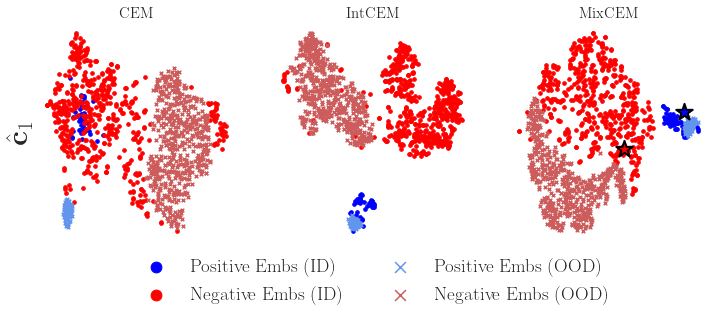

used_embeddings[model_idx].shape = (1160, 2)
used_embeddings[model_idx].shape = (1160, 2)
used_embeddings[model_idx].shape = (1162, 2)


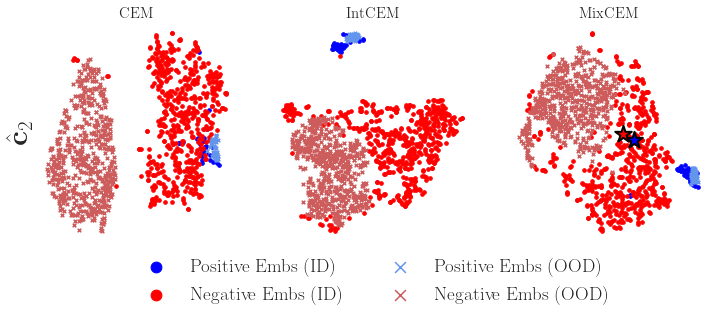

In [79]:
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS

# Now plot things!
for selected_concept, used_embeddings in zip(selected_concepts, tsne_int_embeddings):

    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]

    activation_label = f"Embeddings for {concept_name}"

    mask = id_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    figsize = (4 * (len(models_to_include) - 1), 4)
    fig, axs = plt.subplots(
        1,
        (len(models_to_include) - 1),
        figsize=figsize,
        squeeze=False,
    )

    id_color_active = 'blue'
    ood_color_active = 'cornflowerblue'
    id_color_inactive = 'red'
    ood_color_inactive = 'indianred'
    ignored = 0
    for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
        if real_model_name == 'Hybrid CBM':
            ignored += 1
            continue
        start_idx = 0
        if real_model_name == 'MixCEM':
            start_idx = 2
        model_idx -= ignored
        n_samples = (used_embeddings[model_idx].shape[0] - start_idx)//2
        ax = axs[0, model_idx]
        ax.scatter(
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][mask],
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][mask],
            color=id_color_active,
            label=f"Positive Embs (ID)",
            marker='o',
            alpha=1,
            s=13,
        )
        ax.scatter(
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][neg_mask],
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][neg_mask],
            color=id_color_inactive,
            label=f"Negative Embs (ID)",
            marker='o',
            alpha=1,
            s=13,
        )

        ax.scatter(
            used_embeddings[model_idx][start_idx + n_samples:, 0][mask],
            used_embeddings[model_idx][start_idx + n_samples:, 1][mask],
            color=ood_color_active,
            label=f"Positive Embs (OOD)",
            marker='x',
            alpha=1,
            s=13,
        )

        ax.scatter(
            used_embeddings[model_idx][start_idx + n_samples:, 0][neg_mask],
            used_embeddings[model_idx][start_idx + n_samples:, 1][neg_mask],
            color=ood_color_inactive,
            label=f"Negative Embs (OOD)",
            marker='x',
            alpha=1,
            s=13,
        )
        print("used_embeddings[model_idx].shape =", used_embeddings[model_idx].shape)
        if real_model_name == "MixCEM":
            # Then also plot the global embeddings!
            # And plot the global embeddings
            ax.scatter(
                used_embeddings[model_idx][0:1, 0],
                used_embeddings[model_idx][0:1, 1],
                color='blue',
                # label=r"Positive Global Embedding $\bar{\mathbf{c}}^{(+)}_i$",
                marker='*',
                s=300,
                edgecolor='black',
                linewidths=2,
            )

            ax.scatter(
                 used_embeddings[model_idx][1:2, 0],
                 used_embeddings[model_idx][1:2, 1],
                color='red',
                # label=r"$Negative Global Embedding \bar{\mathbf{c}}^{(-)}_i$",
                marker='*',
                s=300,
                edgecolor='black',
                linewidths=2,
            )

        ax.set_title(real_model_name, fontsize=15)
        if model_idx == 0:
            ax.set_ylabel("$\hat{\mathbf{c}}_{" +str(selected_concept + 1) + "}$", fontsize=30)
        ax.grid(False)
        # Remove the axis line, ticks, and tick labels for the x-axis
        ax.xaxis.set_ticks([])  # Remove tick marks
        ax.xaxis.set_ticklabels([])  # Remove tick labels
        ax.spines['bottom'].set_visible(False)  # Hide the axis line
        ax.spines['top'].set_visible(False)  # Hide the axis line

        # Remove the axis line, ticks, and tick labels for the y-axis (optional)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=19,
        loc='upper center',
        bbox_to_anchor=(-0.7,0),
        ncol=2,
        markerscale=3.,
    )
    plt.savefig(f"figures/concept_embedding_viz.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_embedding_viz.png", bbox_inches='tight')
    plt.show()

In [76]:
mixcem.concept_embeddings.shape

torch.Size([22, 2, 16])